In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from algorithm import *
import time
from tqdm import tqdm
import seaborn as sns
import matplotlib.ticker as mtick
import pandas as pd

# Implementation

In [ ]:
dimensions = [5, 20, 50, 100]
num_points = 200

# Q (positive), b, and radius (delta).
def generate_pos_qbr(dimensions: list, num_points: int, feasible: bool = True):
    Qbrs = []
    for dim in dimensions:
        for _ in range(num_points):
            Q, b = generate_pos_Q_b(dim)
            unconstrained_x_opt = -np.linalg.inv(Q) @ b
            if feasible:
                delta = np.linalg.norm(unconstrained_x_opt) + np.random.random()
                Qbrs.append((Q, b, delta))
            else:
                delta = np.linalg.norm(unconstrained_x_opt) * np.random.random()
                Qbrs.append((Q, b, delta))
    return Qbrs

# Q (negative), b, and radius (delta).
def generate_neg_qbr(dimensions: list, num_points: int):
    Qbrs = []
    for dim in dimensions:
        for _ in range(num_points):
            Q, b = generate_neg_Q_b(dim)
            delta = np.random.random()
            Qbrs.append((Q, b, delta))
    return Qbrs

In [ ]:
# the value for epsilon can affect the result of checking KKT conditions
# because in KKT conditions, we use np.isclose to check if the value is close to 0
# if epsilon is made larger, the parameter 'atol' in np.isclose should also be made larger to avoid false negative

def generate_results (qbrs: list, epsilon_scale: float = 1e-8):
    qbrx = []
    for qbr in qbrs:
        q, b, r = qbr
        epsilon = r * epsilon_scale
        try:
            x_opt = min_quad(q, b, r, epsilon)
            qbrx.append((q, b, r, x_opt))
        except Exception as e:
            print(e)
    return qbrx
    

def check_kkts (qbrx: list, atol: float = 1e-5):
    for qbrx in qbrx:
        q, b, r, x_opt = qbrx
        print("KKT: ", check_kkt(x_opt, q, b, r, atol))

def generate_timed_results (qbrs: list, epsilon_scale: float = 1e-8):
    qbrx = []
    times = []
    for qbr in qbrs:
        q, b, r = qbr
        epsilon = r * epsilon_scale
        try:
            start_time = time.time()
            x_opt = min_quad(q, b, r, epsilon)
            end_time = time.time()
            qbrx.append((q, b, r, x_opt))
            times.append(end_time - start_time)
        except Exception as e:
            # print(e)
            continue
    return qbrx, times

In [ ]:
inputs_1 = generate_pos_qbr(dimensions, num_points, True)
inputs_2 = generate_pos_qbr(dimensions, num_points, False)
inputs_3 = generate_neg_qbr(dimensions, num_points)

## Case 1: Q positive, unconstrained_min feasible

In [ ]:
# check_kkts(generate_results(inputs_1))

## Case 2: Q positive, unconstrained_min infeasible

In [ ]:
check_kkts(generate_results(inputs_2))

## Case 3: Q negative, no unconstrained_min

In [ ]:
# check_kkts(generate_results(inputs_3))

# Benchmark

### Finding optimal value of epsilon

In [ ]:
dimensions = [5, 20, 50, 100]
num_points = 200

epsilons = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11]
case1_times = []
case2_times = []

inputs_1 = generate_pos_qbr(dimensions, num_points, True)
inputs_2 = generate_pos_qbr(dimensions, num_points, False)

for e in tqdm(epsilons):
    _, c1_time = generate_timed_results(inputs_1, e)
    _, c2_time = generate_timed_results(inputs_2, e)
    
    case1_times.append(c1_time)
    case2_times.append(c2_time)

In [ ]:
min_length = min([len(arr) for arr in case2_times])
tmp = []
for i in range(len(case2_times)):
    tmp.append(case2_times[i][:min_length-1])
case2_times = tmp

case1_times = np.array(case1_times)
case2_times = np.array(case2_times)

avg_case1_times = np.mean(case1_times, axis=1)
avg_case2_times = np.mean(case2_times, axis=1)

std_case1_times = np.std(case1_times, axis=1)
std_case2_times = np.std(case2_times, axis=1)

In [ ]:
sns.set_style('whitegrid')

plt.plot(epsilons, avg_case1_times, label='Case 1')
plt.plot(epsilons, avg_case2_times, label='Case 2')
plt.fill_between(epsilons, avg_case1_times - std_case1_times, avg_case1_times + std_case1_times, alpha=0.2)
plt.fill_between(epsilons, avg_case2_times - std_case1_times, avg_case2_times + std_case1_times, alpha=0.2)

plt.title('Average CPU time per convergence')
plt.xlabel(r'Size of $\epsilon$ in relation to $\Delta$')
plt.ylabel('CPU time (s)')
plt.xscale('log')
plt.ylim(0)
plt.gca().invert_xaxis()
plt.legend()
plt.tight_layout()
plt.show()

## Success Rate

In [ ]:
def generate_sucess_results (qbrs: list, epsilon_scale: float = 1e-6):    
    success = 0
    fail = 0
    for qbr in qbrs:
        q, b, r = qbr
        epsilon = r * epsilon_scale
        try:
            x_opt = min_quad(q, b, r, epsilon)
            success += 1
        except Exception as e:
            fail += 1
    return success, fail

In [ ]:
case1_successrate = []
case2_successrate = []
case3_successrate = []
epsilons = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11]
for e in tqdm(epsilons):
    suc1, fail1 = generate_sucess_results(inputs_1, e)
    suc2, fail2 = generate_sucess_results(inputs_2, e)
    suc3, fail3 = generate_sucess_results(inputs_3, e)
    case1_successrate.append(suc1 / (suc1 + fail1))
    case2_successrate.append(suc2 / (suc2 + fail2))
    case3_successrate.append(suc3 / (suc3 + fail3))

In [ ]:
sns.set_style('whitegrid')

plt.plot(epsilons, case1_successrate, label='Case 1')
plt.plot(epsilons, case2_successrate, label='Case 2')
plt.plot(epsilons, case3_successrate, label='Case 3')


plt.title('Overall Sucess Rate')
plt.xlabel(r'Size of $\epsilon$ in relation to $\Delta$')
plt.ylabel('Sucess Rate')
plt.xscale('log')
plt.gca().invert_xaxis()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.tight_layout()
plt.show()

## CPU time with the increasing of dimension

In [60]:
dimensions = [5, 10, 20, 50, 100, 200]

times = []
dims = []
cases = []

times_1 = []
for dim in tqdm(dimensions):
    inputs = generate_pos_qbr([dim], 100, True)
    _, c1_time_results = generate_timed_results(inputs, 1e-6)
    # times_1.append(c1_time_results)
    dims += [dim] * len(c1_time_results)
    cases += ['Case 1'] * len(c1_time_results)
    times += c1_time_results

times_2 = []
for dim in tqdm(dimensions):
    inputs = generate_pos_qbr([dim], 100, False)
    _, c2_time_results = generate_timed_results(inputs, 1e-6)
    # times_2.append(np.mean(np.array(c2_time_results)))
    dims += [dim] * len(c2_time_results)
    cases += ['Case 2'] * len(c2_time_results)
    times += c2_time_results

times_3 = []
for dim in tqdm(dimensions):
    inputs = generate_neg_qbr([dim], 100)
    _, c3_time_results = generate_timed_results(inputs, 1e-6)
    # times_3.append(np.mean(np.array(c3_time_results)))
    dims += [dim] * len(c3_time_results)
    cases += ['Case 3'] * len(c3_time_results)
    times += c3_time_results

data_times = pd.DataFrame({'Dimension': dims, 'Case': cases, 'Time': times})

100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


/Users/qzhng/anaconda3/envs/NO/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/qzhng/anaconda3/envs/NO/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'CPU time (s)')

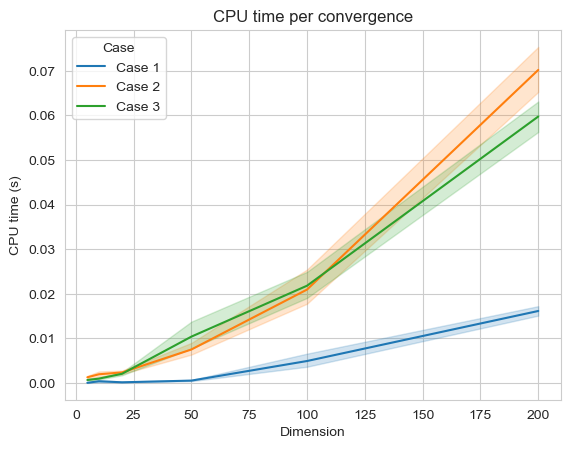

In [61]:
sns.set_style('whitegrid')
sns.lineplot(data=data_times, x='Dimension', y='Time', hue='Case')
plt.title('CPU time per convergence')
plt.xlabel('Dimension')
plt.ylabel('CPU time (s)')

## Number of Iterations with the increasing of dimension

In [72]:
def min_quad_with_iter(Q, b, Delta, epsilon, max_iter=1000):
    iter = 0
    def p(lmbda, Q, b):
        n = len(b)
        return -np.linalg.inv(Q + lmbda * np.eye(n)) @ b

    lmbda_1 = np.min(np.linalg.eigvals(Q))  # smallest eigenvalue of Q
    p_0 = p(0, Q, b)
    if lmbda_1 > 0 and np.linalg.norm(p_0) <= Delta:
        return p_0

    l = max(0, -lmbda_1)
    u = l + 1

    while np.linalg.norm(p(u, Q, b)) > Delta:
        l = u
        u = 2 * u

    # Bisection phase to find the optimal lambda within the interval [l, u]
    while True and iter < max_iter:
        lmbda_prime = 0.5 * (l + u)
        p_prime = p(lmbda_prime, Q, b)
        if np.linalg.norm(p_prime) <= Delta and np.linalg.norm(
                np.linalg.norm(p_prime) - Delta) < epsilon:
            return p_prime, iter
        if np.linalg.norm(p_prime) > Delta:
            l = lmbda_prime
        else:
            u = lmbda_prime
        iter += 1
    if iter >= max_iter:
        raise ValueError(
            "The algorithm did not converge in the bisection phase")

In [73]:
def generate_iter_results(qbrs: list, epsilon_scale: float = 1e-6):
    iters = []
    for qbr in qbrs:
        q, b, r = qbr
        epsilon = r * epsilon_scale
        try:
            _, iter = min_quad_with_iter(q, b, r, epsilon)
            iters.append(iter)
        except Exception as e:
            # print(e)
            continue
    return iters

dimensions = [5, 10, 20, 50, 100, 200]

iters = []
dims = []
cases = []

iters_2 = []
for dim in tqdm(dimensions):
    inputs = generate_pos_qbr([dim], 100, False)
    c2_iter_results = generate_iter_results(inputs)
    dims += [dim] * len(c2_iter_results)
    cases += ['Case 2'] * len(c2_iter_results)
    iters += c2_iter_results

iters_3 = []
for dim in tqdm(dimensions):
    inputs = generate_neg_qbr([dim], 100)
    c3_iter_results  = generate_iter_results(inputs)
    dims += [dim] * len(c3_iter_results)
    cases += ['Case 3'] * len(c3_iter_results)
    iters += c3_iter_results

data_iters = pd.DataFrame({'Dimension': dims, 'Case': cases, 'Iteration': iters})

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


/Users/qzhng/anaconda3/envs/NO/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/qzhng/anaconda3/envs/NO/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Number of iterations')

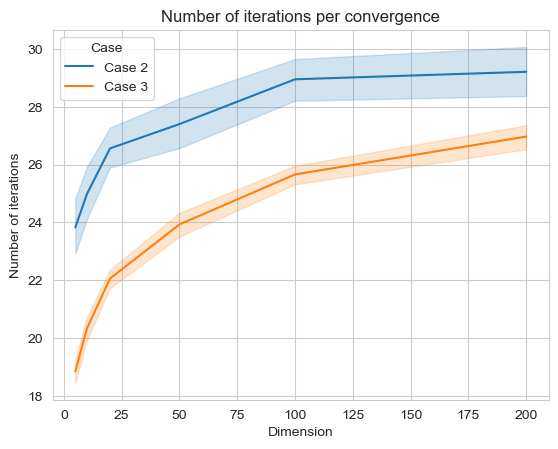

In [74]:
sns.set_style('whitegrid')
sns.lineplot(data=data_iters, x='Dimension', y='Iteration', hue='Case')
plt.title('Number of iterations per convergence')
plt.xlabel('Dimension')
plt.ylabel('Number of iterations')